# Assess Scaling Performance
Assess the scaling performance of "screen-then-evaluate" application

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import json
import os

## Load in the Scaling Runs
We have a list of runs stored in a local folder. Let's get a summary of each

In [3]:
run_summary = []
for d in os.listdir("scaling-runs"):
    with open(os.path.join("scaling-runs", d, "run_params.json")) as fp:
        record = json.load(fp)
    record["study"] = d.split("-")[-1]
    record["name"] = d
    record["path"] = os.path.join("scaling-runs", d)
    run_summary.append(record)
run_summary = pd.DataFrame(run_summary)

In [4]:
run_summary[['nnodes', 'qc_parallelism', 'qc_workers', 'sampling_fraction', 'study']]

,nnodes,qc_parallelism,qc_workers,sampling_fraction,study
0,128,2,64,0.0100,strong
1,8,2,4,0.0100,strong
2,8,2,4,0.0008,weak
3,128,2,64,0.0128,weak
4,256,2,128,0.0100,strong
5,2,2,1,0.0100,strong
6,2,2,1,0.0002,weak
7,256,2,128,0.0256,weak


## Compute Some Basic Information about the Runs
Things that we are going to use in later analyses

In [5]:
def start_time(path):
    """Get the start time for a run"""
    with open(os.path.join(path, "runtime.log")) as fp:
        first_line = fp.readline()
    return datetime.strptime(first_line.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp()

In [6]:
run_summary["start_time"] = run_summary["path"].apply(start_time)

## Assess the Inference Tasks
The first tasks relate to how long it taks to evaluate the search space

In [7]:
screen_results = run_summary[["name", "path", "nnodes", "start_time", "study"]].copy().sort_values("nnodes")

Compute the time until first task starts and completes on compute node

In [8]:
def compute_start(path):
    screen_results = pd.read_json(os.path.join(path, "inference_records.jsonld"), lines=True)
    return screen_results["time_compute_started"].min() 

In [9]:
screen_results["first_compute_start"] = screen_results["path"].apply(compute_start) - screen_results["start_time"]

In [10]:
def first_complete(path):
    screen_results = pd.read_json(os.path.join(path, "inference_records.jsonld"), lines=True)
    return screen_results["time_result_received"].min() 

In [11]:
screen_results["first_compute_complete"] = screen_results["path"].apply(first_complete) - screen_results["start_time"]

Get the number and time required for evaluation

In [12]:
def total_count(path):
    screen_results = pd.read_json(os.path.join(path, "inference_records.jsonld"), lines=True)
    return screen_results["task_info"].apply(lambda x: x["chunk_size"]).sum()
screen_results["num_screened"] = screen_results["path"].apply(total_count)

In [13]:
def time_complete(path):
    screen_results = pd.read_json(os.path.join(path, "inference_records.jsonld"), lines=True)
    return screen_results["time_result_received"].max()
screen_results["time_complete"] = screen_results["path"].apply(time_complete) - screen_results["start_time"]

Get the overhead statistics

In [14]:
overhead_results = []
for p, n in screen_results[["path", "nnodes"]].values:
    data = pd.read_json(os.path.join(p, "inference_records.jsonld"), lines=True).sort_values('time_created').iloc[n:]
    overhead_results.append({
        'client_to_method-server': (data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])).median(),
        'worker_to_method-server': (data['time_result_sent'] - (data['time_compute_started']
                                                                  + data['time_running']
                                                                  + data['time_deserialize_inputs']
                                                                  + data['time_serialize_results'])).median(),
        'method-server_to_client': (data['time_result_received'] - (data['time_result_sent'] + data['time_deserialize_results'])).median(),
        'serialization': data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c]].sum(axis=1).median()
    })
overhead_cols = list(overhead_results[0].keys())
screen_results = pd.concat([screen_results, pd.DataFrame(overhead_results)], axis=1).sort_values('nnodes')

Get the time to load the ML workers

In [27]:
def get_worker_start_times(path):
    """Get the median time until workers first reports"""
    # Get the log records that are Parsl starting or a worker starting
    with open(os.path.join(path, 'runtime.log')) as fp:
        log_lines = [l.split(" - ")[0] for l in fp if '[MAIN] Adding manager' in l]
    
    # Compute the start time
    times = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S,%f').timestamp() for x in log_lines]
    return np.percentile(times, 50)
screen_results['time_to_worker_start'] = screen_results['path'].apply(get_worker_start_times) - screen_results['start_time']

Estimate the TF load time as the time between the median worker starting and the median computation start.
Each worker must unpickle the function before starting computations, which requires loading Tensorflow.

In [30]:
def get_tf_load_times(record):
    data = pd.read_json(os.path.join(record["path"], "inference_records.jsonld"), lines=True).sort_values('time_compute_started')[:record["nnodes"]]
    return data["time_compute_started"].median()
screen_results['tf_load_time'] = screen_results.apply(get_tf_load_times, axis=1) - screen_results['time_to_worker_start'] - screen_results['start_time']

### Make Plots

Plot the evaluation rates

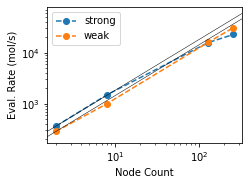

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), sharey=True)

for gid, group in screen_results.groupby("study"):

    # Eval rate from logging start
    ax.loglog(group["nnodes"], group["num_screened"] / group["time_complete"], 'o--', label=gid)

    # Plot the baseline
    smallest_run = group.iloc[0]
    baseline_rate = smallest_run["num_screened"] / smallest_run["time_complete"] / smallest_run["nnodes"]

    # Put the ideal
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.multiply(baseline_rate, ax.get_xlim()), 'k', lw=0.5)

ax.set_ylabel("Eval. Rate (mol/s)")
ax.set_xlabel("Node Count")
ax.legend()

Most of this time is probably start up costs

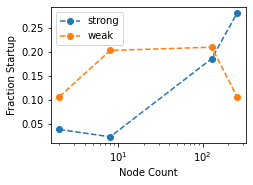

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in screen_results.groupby("study"):
    ax.semilogx(group["nnodes"], group["first_compute_start"] / group["time_complete"], 'o--', label=gid)

ax.set_ylabel("Fraction Startup")
ax.set_xlabel("Node Count")
ax.legend()

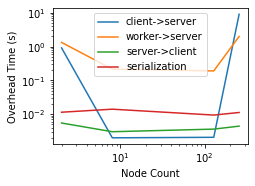

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = screen_results.query("study=='weak'")
for c in overhead_cols:
    ax.loglog(subset["nnodes"], subset[c], label=c.replace("_to_", "->").replace('method-server', 'server'))
    
ax.set_ylabel("Overhead Time (s)")
ax.set_xlabel("Node Count")
ax.legend()

Time to launch Parsl workers and for them to load TF

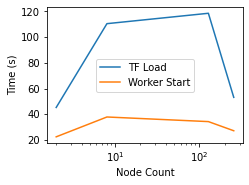

In [34]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = screen_results.query("study=='weak'")
ax.semilogx(subset["nnodes"], subset['tf_load_time'], label='TF Load')
ax.semilogx(subset["nnodes"], subset['time_to_worker_start'], label='Worker Start')
    
ax.set_ylabel("Time (s)")
ax.set_xlabel("Node Count")
ax.legend()

## Dig into to scaling performance
Try to determine where the bottlenecks are

Plot a trace of the "client-server" runs over time

In [34]:
run = subset.query('nnodes==256').iloc[0]
data = pd.read_json(os.path.join(run['path'], 'inference_records.jsonld'), lines=True)
data['walltime'] = data['time_created'] - data['time_created'].min()
data['client-to-server'] = data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])

Text(0, 0.5, 'Client->Server Time (s)')

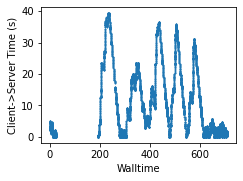

In [41]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(data['walltime'], data['client-to-server'], s=0.6)
#ax.set_xlim(0, 4)
ax.set_xlabel('Walltime')
ax.set_ylabel('Client->Server Time (s)')

We do assemble a sizeable backlog of tasks waiting in Redis to be submitted to compute resources. Maybe need to make the chunk size per task larger

## QC Computation Scaling
At least see if the overhead changes, measuring the performance of the individual NWChem calcualtions is beyond our efforts for now

In [20]:
simulate_results = run_summary[["name", "path", "nnodes", "start_time", "study"]].copy().sort_values("nnodes")

Get the overhead times

In [21]:
overhead_results = []
for p, n in simulate_results[["path", "nnodes"]].values:
    data_path = os.path.join(p, "simulation_records.jsonld")
    if not os.path.isfile(data_path):
        continue
    data = pd.read_json(data_path, lines=True).sort_values('time_created')
    overhead_results.append({
        'path': p,
        'client_to_method-server': (data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])).median(),
        'worker_to_method-server': (data['time_result_sent'] - (data['time_compute_started']
                                                                  + data['time_running']
                                                                  + data['time_deserialize_inputs']
                                                                  + data['time_serialize_results'])).median(),
        'method-server_to_client': (data['time_result_received'] - (data['time_result_sent'] + data['time_deserialize_results'])).median(),
        'serialization': data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c]].sum(axis=1).median()
    })
overhead_cols = list(overhead_results[0].keys())
overhead_cols.remove("path")

In [22]:
simulate_results = simulate_results.merge(pd.DataFrame(overhead_results), on='path')

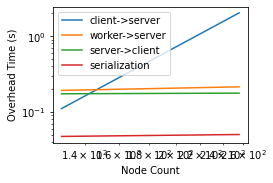

In [42]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = simulate_results.query("study=='weak'")
for c in overhead_cols:
    ax.loglog(subset["nnodes"], subset[c], label=c.replace("_to_", "->").replace('method-server', 'server'))
    
ax.set_ylabel("Overhead Time (s)")
ax.set_xlabel("Node Count")
ax.legend()

Again, the time it takes to submit tasks is the rate-limiting step.